In [3]:
#필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline
# 시각화 라이브러리 설정
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

In [4]:
df = pd.read_csv("creditcard.csv")

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [19]:
df.shape

(284807, 31)

In [7]:
df.isnull().values.any()

False

In [8]:
# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 2022
LABELS = ["Normal", "Fraud"]

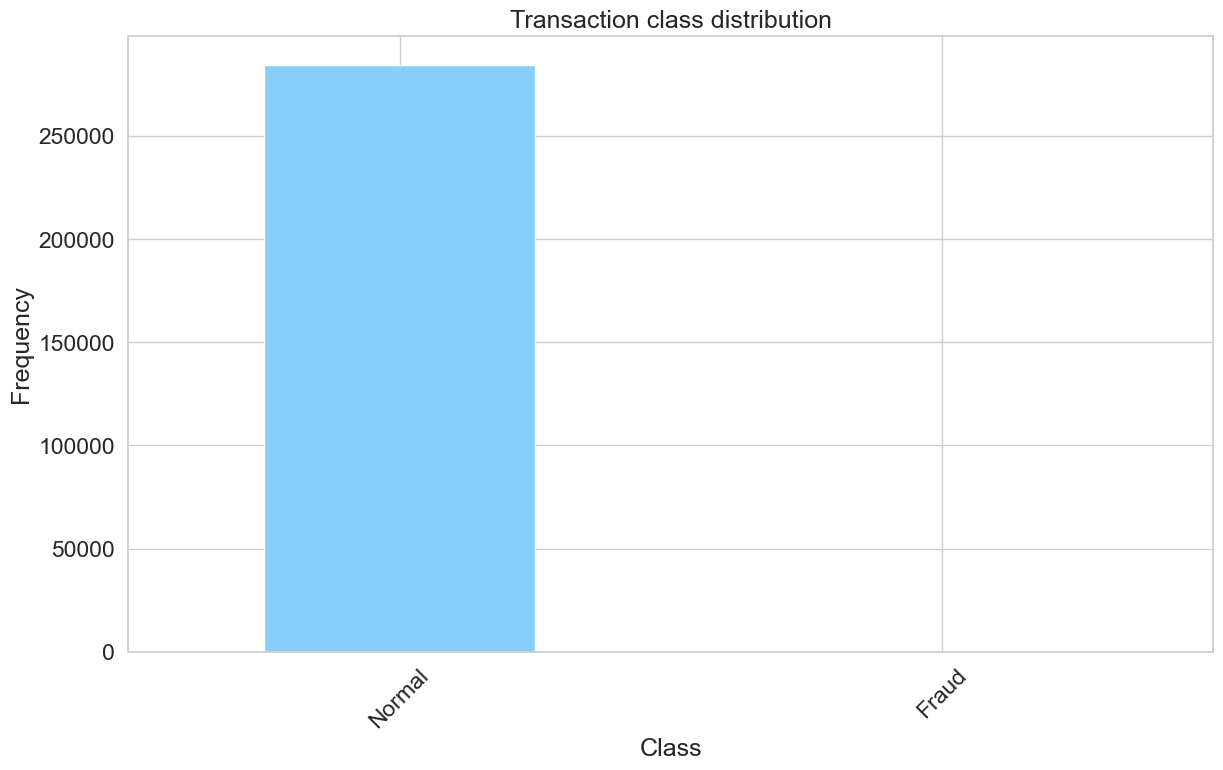

In [9]:
count_classes = pd.value_counts(df['Class'])
#rot은 글자를 회전 시킴
count_classes.plot(kind = 'bar', rot=45, color="lightskyblue")
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [10]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [11]:
normal.shape

(284315, 31)

In [20]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [22]:
#Class의 갯수를 세수 표로 만듦 또한 reset_index()를 통하여 index에 대한 표도 만들어줌 
table = df['Class'].value_counts().to_frame().reset_index()
# 전체의 데이터에서 몇 프로를 차지 하는지 표를 추가하고 소수점 4째자리까지 추출
table['Percent(%)'] = table["Class"].apply(lambda x : round(100*float(x) / len(df), 4))
#index와 Class의 이름을 바꾸어줌
table= table.rename(columns = {"index" : "Target", "Class" : "Count"})

table

,Target,Count,Percent(%)
0,0,284315,99.8273
1,1,492,0.1727


In [23]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [24]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

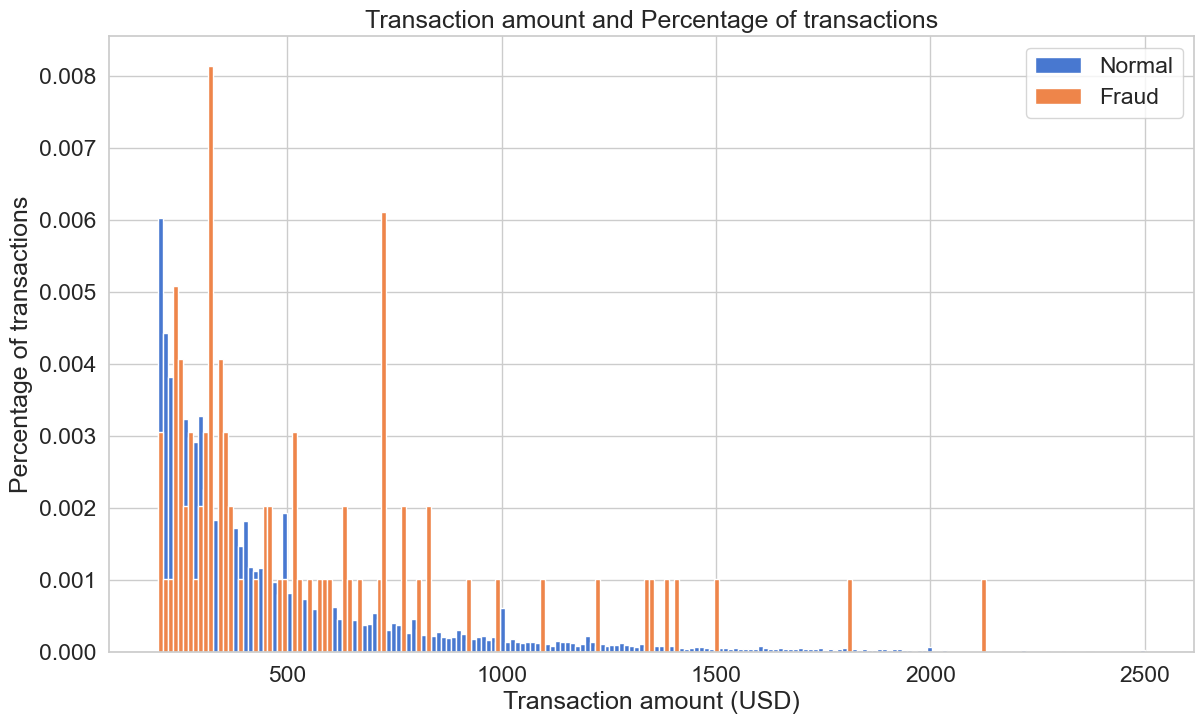

In [25]:
#정상과 사기거래의 거래량과 금액을 graph로 나타냄
bins = np.linspace(200, 2500, 200)
plt.hist(normal.Amount, bins=bins, alpha=1, density=True, label='Normal')
plt.hist(frauds.Amount, bins=bins, alpha=1, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Transaction amount and Percentage of transactions")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions");
plt.show()

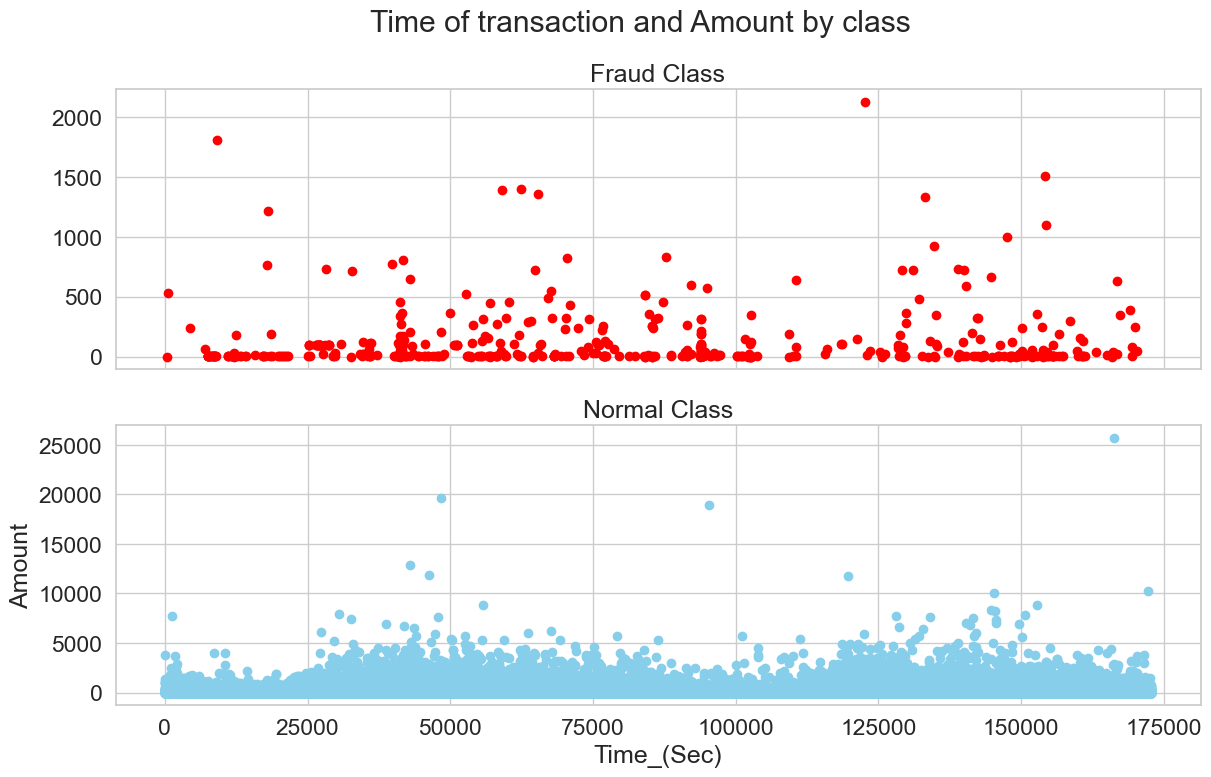

In [26]:
#정상거래와 사기거래의 시간(초)에 따른 거래량을 알아보고자함
#sub plot이 2개의 graph가 그릴수있도록 설정해주고  x축을 설정함
function,(ax1, ax2) = plt.subplots(2, 1, sharex=True)
function.suptitle('Time of transaction and Amount by class')
#시간에 따른 사기거래의 거래량
ax1.scatter(frauds.Time, frauds.Amount,color="red")
ax1.set_title('Fraud Class')
#시간에 따른 정상거래의 거래량
ax2.scatter(normal.Time, normal.Amount,color="skyblue")
ax2.set_title('Normal Class')

plt.xlabel('Time_(Sec)')
plt.ylabel('Amount')
plt.show()

In [27]:
from sklearn.preprocessing import StandardScaler
#시간이 그렇게 중요한 요소가 아니라 판단되어 시간을 지움 
data = df.drop(['Time'], axis=1)
#거래량을 StandardScaler를 통해 값들을 스케일링 함, 이유는 평균을 제거하고 데이터를 단위 분산으로 조정하기에 이상치가 있다면 데이터의 확산은 매우 달라져서 이상치에 매우 민감
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [28]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=RANDOM_SEED)
#이상치탐지에는 중요한특성이 있는데 train데이터는 정상인 데이터만 사용함
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(199000, 29)

In [30]:
#X_train의 열의 갯수:28개
input_dim = X_train.shape[1]

encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
#regularizers를 L1으로 설정 하였음
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [31]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 14)                420       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 7)                 56        
                                                                 
 dense_3 (Dense)             (None, 29)                232       
                                                                 
Total params: 813
Trainable params: 813
Non-trainable params: 0
_________________________________________________________________


In [32]:
nb_epoch = 100
batch_size = 32
#
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
#ModelCheckpoint로 성능 좋은모델을 저장함
checkpointer = ModelCheckpoint(filepath="model.h",
                               verbose=0,
                               save_best_only=True)
#TensorBoard는 TensorFlow에서 발생한 로그를 표시함
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
6219/6219 [==============================] - 9s 1ms/step - loss: 0.8033 - accuracy: 0.5887 - val_loss: 0.7945 - val_accuracy: 0.6360
Epoch 2/100
6219/6219 [==============================] - 8s 1ms/step - loss: 0.7373 - accuracy: 0.6477 - val_loss: 0.7780 - val_accuracy: 0.6662
Epoch 3/100
6219/6219 [==============================] - 8s 1ms/step - loss: 0.7252 - accuracy: 0.6672 - val_loss: 0.7714 - val_accuracy: 0.6646
Epoch 4/100
6219/6219 [==============================] - 8s 1ms/step - loss: 0.7188 - accuracy: 0.6801 - val_loss: 0.7633 - val_accuracy: 0.6802
Epoch 5/100
6219/6219 [==============================] - 8s 1ms/step - loss: 0.7144 - accuracy: 0.6932 - val_loss: 0.7599 - val_accuracy: 0.6888
Epoch 6/100
6219/6219 [==============================] - 8s 1ms/step - loss: 0.7106 - accuracy: 0.7020 - val_loss: 0.7565 - val_accuracy: 0.7074
Epoch 7/100
6219/6219 [==============================] - 9s 1ms/step - loss: 0.7079 - accuracy: 0.7079 - val_loss: 0.7524 - val_ac

6219/6219 [==============================] - 8s 1ms/step - loss: 0.6957 - accuracy: 0.7287 - val_loss: 0.7427 - val_accuracy: 0.7279
Epoch 41/100
6219/6219 [==============================] - 8s 1ms/step - loss: 0.6960 - accuracy: 0.7276 - val_loss: 0.7468 - val_accuracy: 0.7153
Epoch 42/100
6219/6219 [==============================] - 8s 1ms/step - loss: 0.6957 - accuracy: 0.7283 - val_loss: 0.7446 - val_accuracy: 0.7165
Epoch 43/100
6219/6219 [==============================] - 8s 1ms/step - loss: 0.6957 - accuracy: 0.7288 - val_loss: 0.7397 - val_accuracy: 0.7323
Epoch 44/100
6219/6219 [==============================] - 8s 1ms/step - loss: 0.6958 - accuracy: 0.7279 - val_loss: 0.7394 - val_accuracy: 0.7304
Epoch 45/100
6219/6219 [==============================] - 8s 1ms/step - loss: 0.6958 - accuracy: 0.7292 - val_loss: 0.7419 - val_accuracy: 0.7311
Epoch 46/100
6219/6219 [==============================] - 8s 1ms/step - loss: 0.6956 - accuracy: 0.7292 - val_loss: 0.7394 - val_accuracy

6219/6219 [==============================] - 9s 1ms/step - loss: 0.6944 - accuracy: 0.7282 - val_loss: 0.7378 - val_accuracy: 0.7290
Epoch 94/100
6219/6219 [==============================] - 9s 1ms/step - loss: 0.6945 - accuracy: 0.7297 - val_loss: 0.7375 - val_accuracy: 0.7257
Epoch 95/100
6219/6219 [==============================] - 9s 1ms/step - loss: 0.6945 - accuracy: 0.7288 - val_loss: 0.7376 - val_accuracy: 0.7319
Epoch 96/100
6219/6219 [==============================] - 8s 1ms/step - loss: 0.6944 - accuracy: 0.7294 - val_loss: 0.7381 - val_accuracy: 0.7288
Epoch 97/100
6219/6219 [==============================] - 8s 1ms/step - loss: 0.6945 - accuracy: 0.7293 - val_loss: 0.7386 - val_accuracy: 0.7238
Epoch 98/100
6219/6219 [==============================] - 8s 1ms/step - loss: 0.6951 - accuracy: 0.7276 - val_loss: 0.7380 - val_accuracy: 0.7254
Epoch 99/100
6219/6219 [==============================] - 8s 1ms/step - loss: 0.6942 - accuracy: 0.7287 - val_loss: 0.7388 - val_accuracy

In [33]:
autoencoder = load_model('model.h')

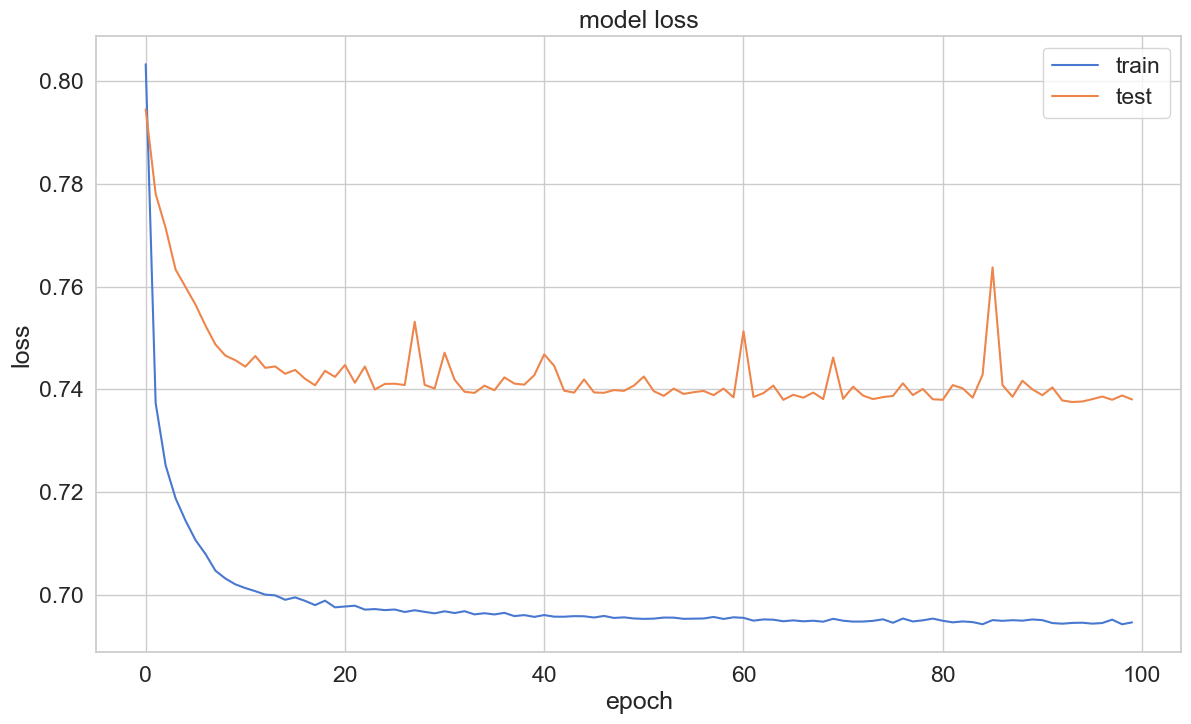

In [34]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [81]:
predictions = autoencoder.predict(X_test)
#np.power(a,b)는 제곱연산을 할때 사용되면 a^b를 뜻함
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
percent=[0.001,0.1,0.9,0.999]
error_df.describe(percentiles=percent)

2671/2671 [==============================] - 2s 703us/step


,reconstruction_error,true_class
count,85443.000000,85443.000000
mean,0.736549,0.001498
std,3.956596,0.038676
min,0.056798,0.000000
0.1%,0.075406,0.000000
10%,0.161165,0.000000
50%,0.377659,0.000000
90%,0.981573,0.000000
99.9%,44.121528,1.000000
max,395.369491,1.000000


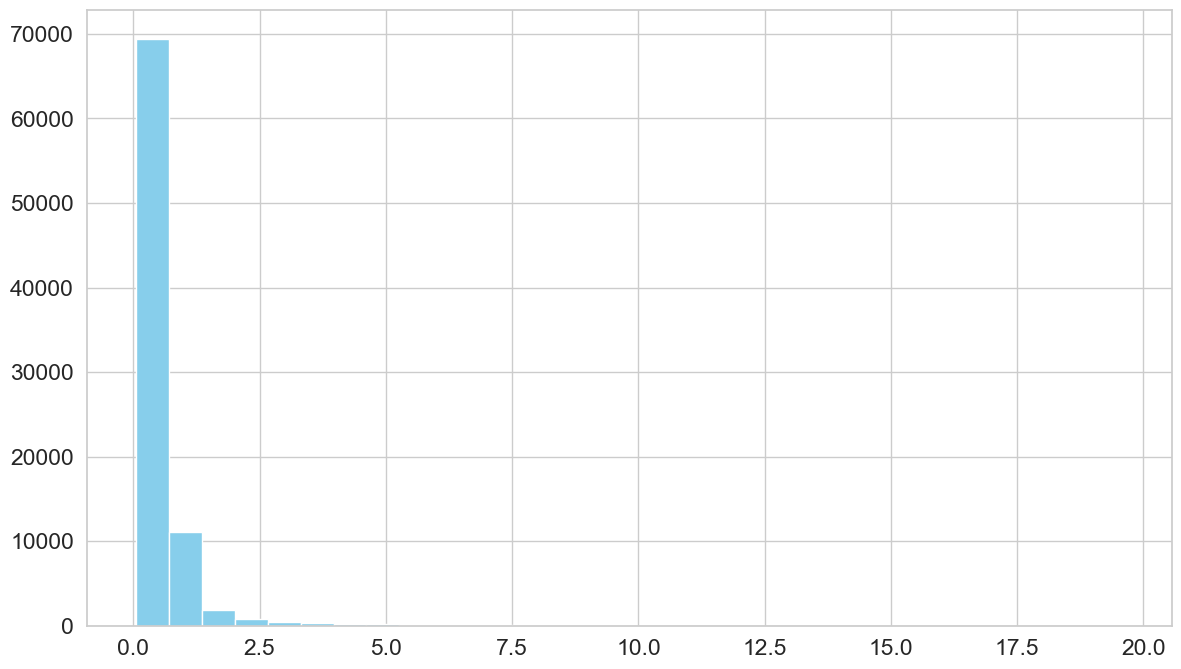

In [76]:
# 정상데이터의 reconstruction_error분포
fig = plt.figure()
#111은 1행째의 1열의 첫 번째라는 의미임
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 20)]
normal_error_df= ax.hist(normal_error_df.reconstruction_error.values, bins=30, color = "skyblue")

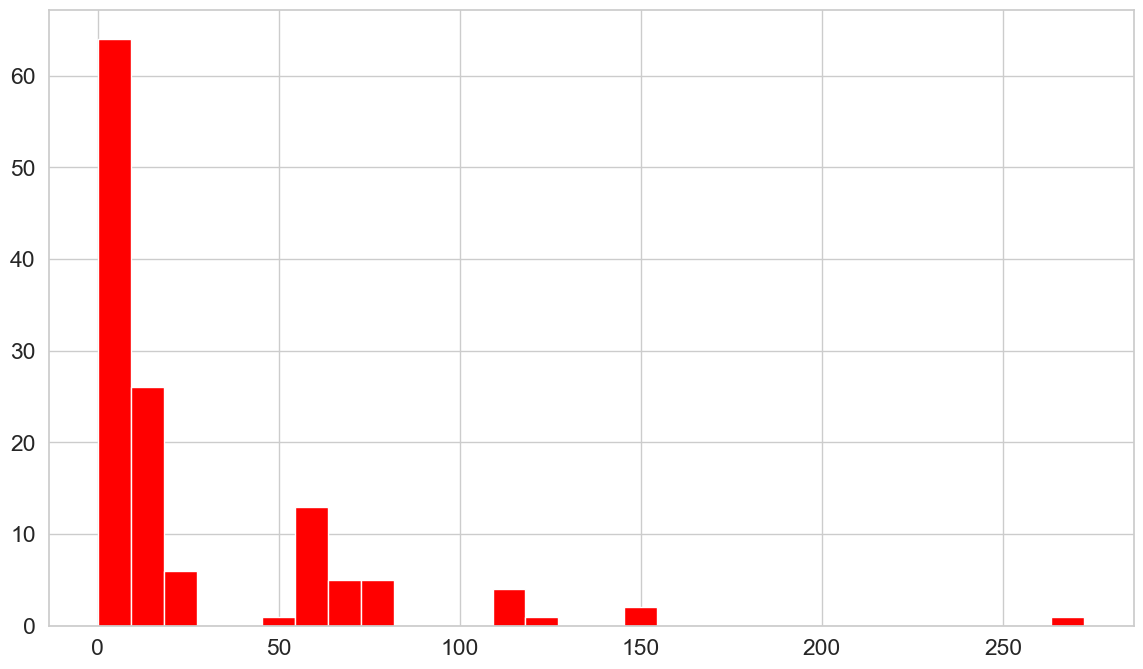

In [77]:
# 사기데이터의 reconstruction_error분포
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
fraud_error_df = ax.hist(fraud_error_df.reconstruction_error.values, bins=30 ,color = "red")

In [41]:
#sklearn의 기법들 
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

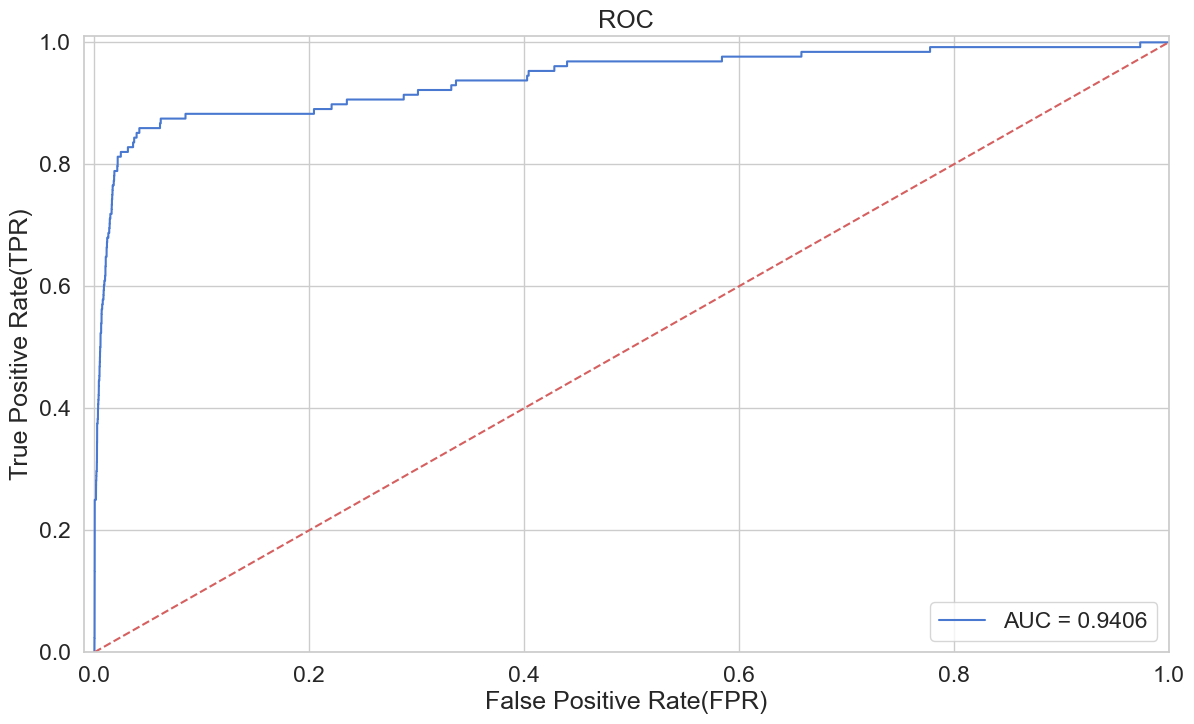

In [82]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('ROC')
#AUROC를 계산
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate(TPR)')
plt.xlabel('False Positive Rate(FPR)')
plt.show();


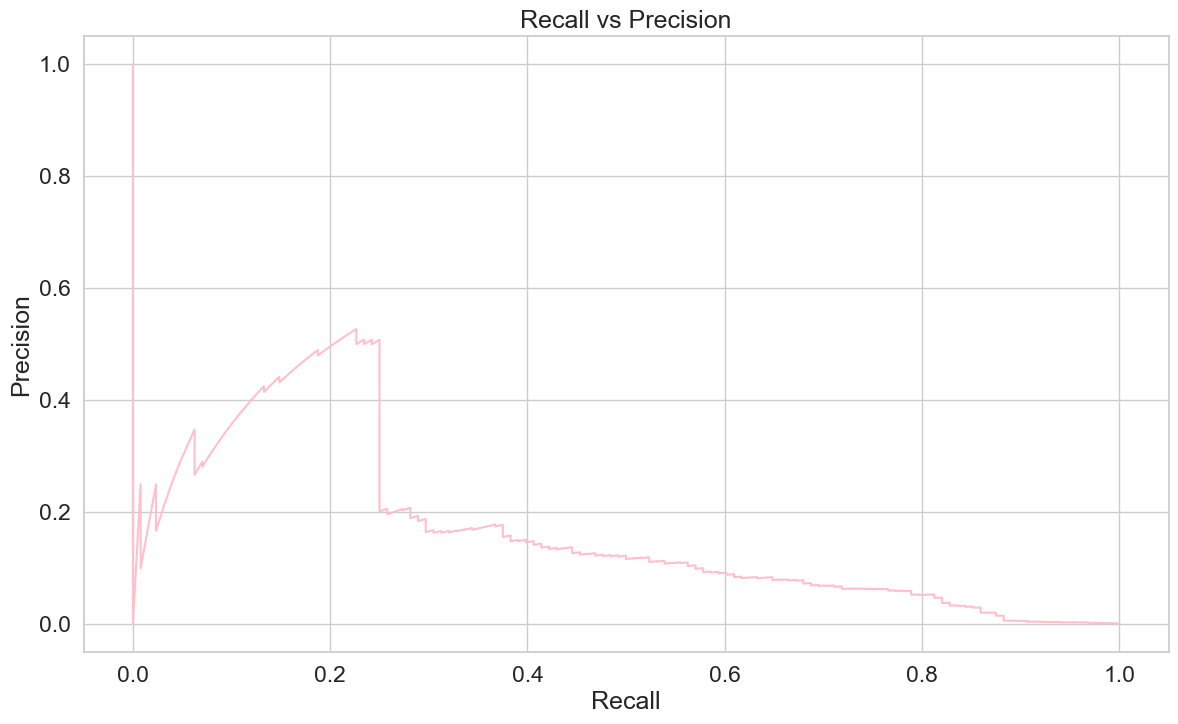

In [84]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'pink', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


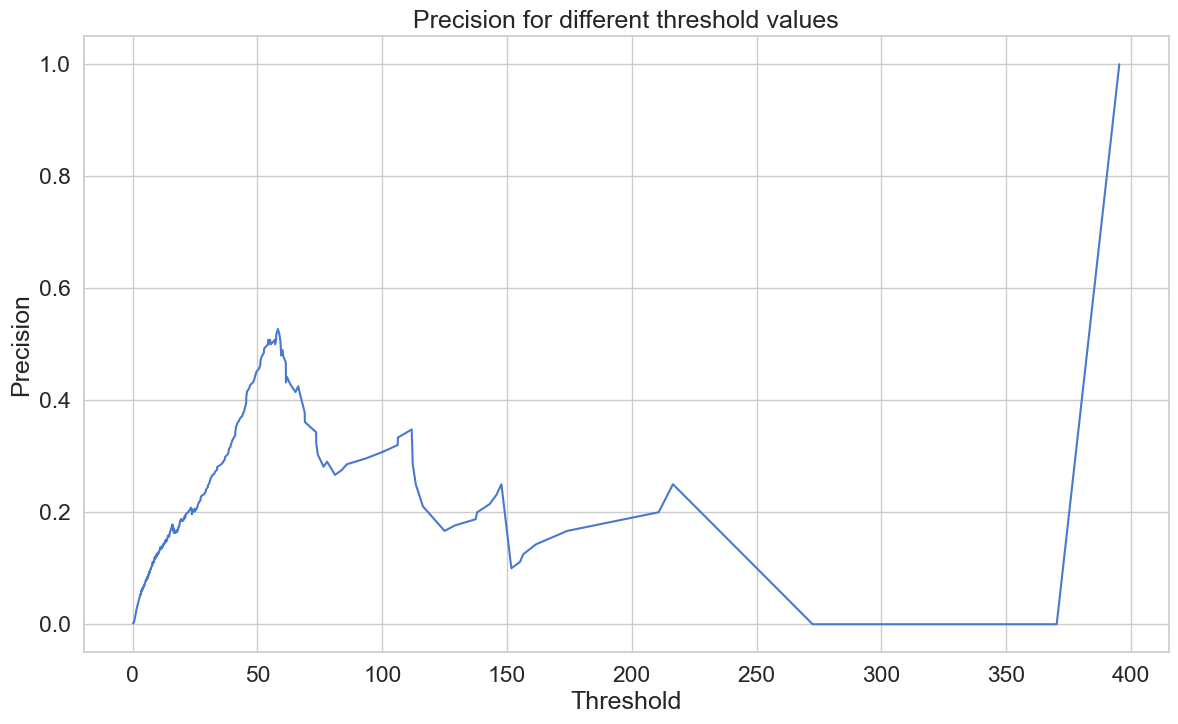

In [45]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

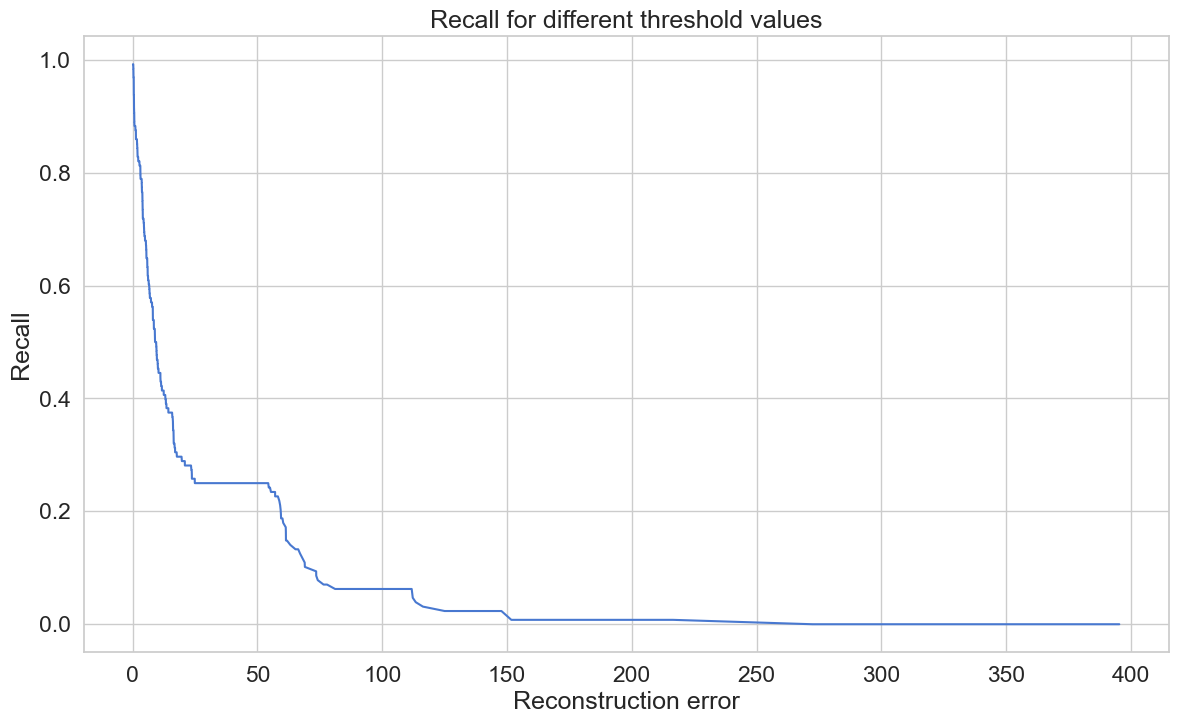

In [46]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [88]:
threshold = 3
#threshold = 58

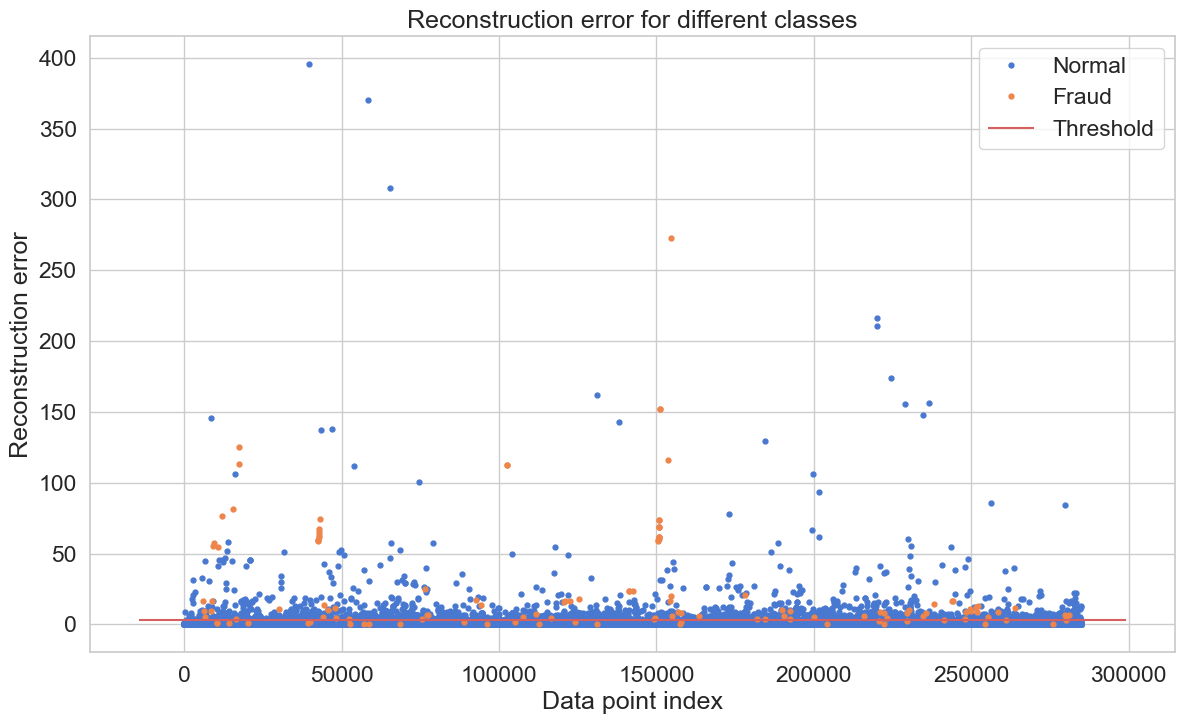

In [89]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

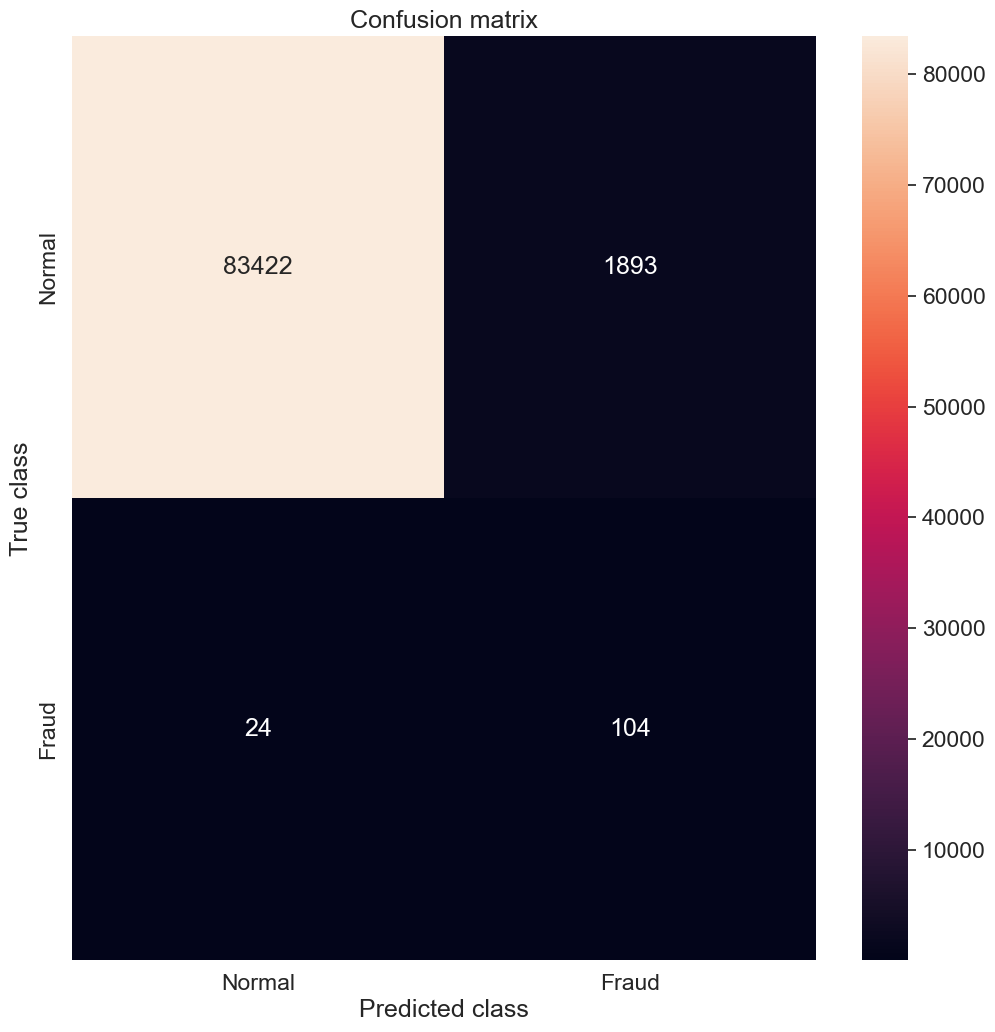

In [90]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()